In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.5 MB/s eta 0:00:00


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import packages**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm import tqdm
from tqdm import trange
import os

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

## **Read data files**

In [ ]:
train_data = pd.read_csv('Data/blp23_sentiment_train.tsv', sep = '\t')
dev_data = pd.read_csv('Data/blp23_sentiment_dev.tsv', sep='\t')
test_data = pd.read_csv('Data/blp23_sentiment_dev_test.tsv', sep='\t')

In [ ]:
train_texts = train_data['text'].tolist()
dev_texts = dev_data['text'].tolist()

train_label = train_data['label'].tolist()
dev_label = dev_data['label'].tolist()

In [ ]:
label_to_id = {'Positive' : 1, 'Neutral': 0, 'Negative': 2}
id_to_label = {k: v for v, k in label_to_id.items()}
print(id_to_label)

{1: 'Positive', 0: 'Neutral', 2: 'Negative'}


In [ ]:
BATCH_SIZE = 32
max_len = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

In [ ]:
class BertInputItem(object):
  def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
    self.text = text
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
  input_items = []
  examples = zip(example_texts, example_labels)
  for (ex_index, (text, label)) in enumerate(examples):

    input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
    if len(input_ids) > max_seq_length:
      input_ids = input_ids[:max_seq_length]

    segment_ids = [0]*len(input_ids)
    input_mask = [1]*len(input_ids)
    padding = [0]*(max_seq_length - len(input_ids))
    input_ids += padding
    input_mask += padding
    segment_ids += padding

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    label_id = label2idx[label]

    input_items.append(BertInputItem(text = text, input_ids = input_ids, input_mask = input_mask, segment_ids = segment_ids, label_id = label_id))
  return input_items

## **Preparing input data for model**

In [ ]:
train_features = convert_examples_to_inputs(train_texts, train_label, label_to_id, max_len, tokenizer, verbose=0)
dev_features = convert_examples_to_inputs(dev_texts, dev_label, label_to_id, max_len, tokenizer, verbose=0)

Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

def get_data_loader(features, max_seq_length, batch_size, shuffle=True):
  all_input_ids = torch.tensor([f.input_ids for f in features], dtype = torch.long)
  all_input_mask = torch.tensor([f.input_mask for f in features], dtype = torch.long)
  all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype = torch.long)
  all_label_ids = torch.tensor([f.label_id for f in features], dtype = torch.long)
  data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

  dataloader = DataLoader(data, shuffle=shuffle, batch_size = batch_size)
  return dataloader

## **Creating dataloader**

In [ ]:
train_dataloader = get_data_loader(train_features, max_len, BATCH_SIZE, shuffle=True)
dev_dataloader = get_data_loader(dev_features, max_len, BATCH_SIZE, shuffle=False)

## **Initializing model**

In [ ]:
from transformers.models.bert.modeling_bert import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(label_to_id))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

## **Defining hyperparameters**

In [ ]:
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
import math


GRADIENT_ACCUMULATION_STEPS = 1
EPOCHS = 15
LEARNING_RATE = 5 * 10**-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(train_dataloader.dataset)/BATCH_SIZE/GRADIENT_ACCUMULATION_STEPS * EPOCHS)
num_warmup_steps = int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params' : [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params' : [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 00.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr = LEARNING_RATE, correct_bias = False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps, num_training_steps = num_train_steps)

In [ ]:
def evaluate(model, dataloader):
  model.eval()

  eval_loss = 0
  nb_eval_steps = 0
  predicted_labels, correct_labels = [], []

  for step, batch in enumerate(tqdm(dataloader, desc = "Evaluation iteration")):
      batch = tuple(t.to(device) for t in batch)
      input_ids, input_mask, segment_ids, label_ids = batch

      with torch.no_grad():
        outputs = model(input_ids, attention_mask = input_mask, token_type_ids = segment_ids, labels=label_ids)
      tmp_eval_loss = outputs[0]
      logits = outputs[1]
      outputs = np.argmax(logits.to('cpu'), axis=1)
      label_ids = label_ids.to('cpu').numpy()

      predicted_labels += list(outputs)
      correct_labels += list(label_ids)

      eval_loss += tmp_eval_loss.mean().item()
      nb_eval_steps += 1

  eval_loss = eval_loss/nb_eval_steps
  correct_labels = np.array(correct_labels)
  predicted_labels = np.array(predicted_labels)


  return eval_loss, correct_labels, predicted_labels


In [ ]:
OUTPUT_DIR = 'Saved_dir'
MODEL_NAME = "bert-base-multilingual-cased"
MODEL_FILE_NAME = 'pytorch_model.bin'
PATIENCE = 2

## **Training loop**

In [ ]:
train_loss_history = []
dev_loss_history = []

no_improvement = 0
for e in trange(int(EPOCHS), desc="Epoch"):
    model.train()
    tr_loss = 0

    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        outputs = model(input_ids, attention_mask = input_mask, token_type_ids = segment_ids, labels = label_ids)

        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss/GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm(model.parameters(), MAX_GRAD_NORM)

            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    dev_loss, _, _ = evaluate(model, dev_dataloader)

    print("Loss history : ", dev_loss_history)
    #print("Dev loss : ", dev_loss)

    if len(dev_loss_history) == 0 or dev_loss < min(dev_loss_history):
        no_improvement = 0
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_dir = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
        torch.save(model_to_save.state_dict(), output_model_dir)
        print(f"Model saved at epoch {e}")
    else:
        no_improvement += 1

    if no_improvement >= PATIENCE:
        print("No improvement on development set. Finish training")
        break

    dev_loss_history.append(dev_loss)
    train_loss_history.append(tr_loss/len(train_dataloader))




Training iteration: 100%|██████████| 1103/1103 [03:33<00:00,  5.16it/s]

Evaluation iteration: 100%|██████████| 123/123 [00:06<00:00, 17.76it/s]


Loss history :  []


Epoch:   7%|▋         | 1/15 [03:43<52:08, 223.46s/it]

Model saved at epoch 0



Training iteration: 100%|██████████| 1103/1103 [03:20<00:00,  5.50it/s]

Evaluation iteration: 100%|██████████| 123/123 [00:06<00:00, 18.03it/s]


Loss history :  [0.8327641826335007]


Epoch:  13%|█▎        | 2/15 [07:17<47:15, 218.12s/it]

Model saved at epoch 1



Training iteration: 100%|██████████| 1103/1103 [03:20<00:00,  5.50it/s]

Epoch:  20%|██        | 3/15 [10:45<42:39, 213.28s/it]

Loss history :  [0.8327641826335007, 0.8058332691832286]



Training iteration: 100%|██████████| 1103/1103 [03:21<00:00,  5.49it/s]

Epoch:  20%|██        | 3/15 [14:13<56:53, 284.46s/it]

Loss history :  [0.8327641826335007, 0.8058332691832286, 0.8193518815001821]
No improvement on development set. Finish training


## **Train-Val loss plot**

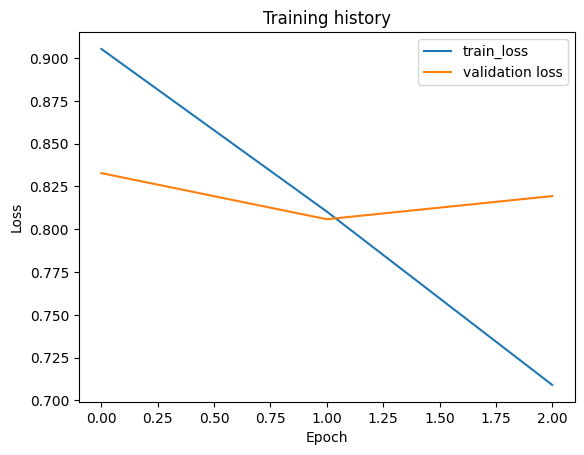

In [ ]:
plt.plot(train_loss_history, label='train_loss')
plt.plot(dev_loss_history, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

## **Calculating metrics for evaluation**

In [ ]:
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc:storage)
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", state_dict=model_state_dict, num_labels = len(label_to_id))
model.to(device)

model.eval()

#_, train_correct, train_predicted = evaluate(model, train_dataloader)
_, dev_correct, dev_predicted = evaluate(model, dev_dataloader)

#print("Training performance : ", precision_recall_fscore_support(train_correct, train_predicted, average='micro'))
print("Dev performance : ", precision_recall_fscore_support(dev_correct, dev_predicted, average='micro'))

from sklearn.metrics import f1_score

print("Micro F1-score = ", f1_score(dev_correct, dev_predicted, average='micro'))

Evaluation iteration: 100%|██████████| 123/123 [00:06<00:00, 18.81it/s]

Dev performance :  (0.6390442297915607, 0.6390442297915607, 0.6390442297915607, None)
Micro F1-score =  0.6390442297915607
